# Lab: Linear Regression

## Libraries / Data

Basic imports and Boston dataset loading

In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

boston = pd.read_csv('../datasets/boston.csv', index_col=False)

We will seek to predict __medv__ using 13 predictors such as __rm__ (average number of rooms per house), __age__ (average age of houses), and __lstat__ (percent of households with low socioeconomic status).

In [2]:
"[{}]".format(', '.join(boston.columns.tolist()))

'[crim, zn, indus, chas, nox, rm, age, dis, rad, tax, ptratio, black, lstat, medv]'

We will start by using the `OLS` function to fit a simple linear regression model, with __medv__ as the response and __lstat__ as the predictor.

_Note: we'll use the `statsmodels` package instead of `sklearn` because of the additional statistical information on the linear regression functions/classes._

In [3]:
import statsmodels.api as sm

X = boston.lstat
X = sm.add_constant(X) # this is needed to add an intercept to our linear model.
y = boston.medv

model = sm.OLS(y, X)
results = model.fit();

For more detailed information, we use `results.summary()`. This gives us p-values and standard errors for the coefficients, as well as the R2 statistic and F-statistic for the model.

In [4]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Sun, 05 Aug 2018   Prob (F-statistic):           5.08e-88
Time:                        20:40:48   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.5538      0.563     61.415      0.000      33.448      35.659
lstat         -0.9500      0.039    -24.528      0.000      -1.026      -0.874
==============================================================================
Omnibus:                      137.043   Durbin-Watson:                   0.892
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              291.373
Skew:                           1.453   Prob(JB):                     5.36e-64
Kurtosis:                       5.319   Cond. No.                         29.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In order to obtain a confidence interval for the coefficient estimates, we can use the `results.conf_int()` method.

In [5]:
results.conf_int()

,0,1
const,33.448457,35.659225
lstat,-1.026148,-0.873951


We can use OLS `predict` method to estimate __medv__ based on new __lstat__ values

In [6]:
Xtest = [5, 10, 15]
Xtest = sm.add_constant(Xtest)

In [7]:
results.predict(Xtest)

array([29.80359411, 25.05334734, 20.30310057])

The `summary_frame()` function can be used to produce confidence intervals and prediction intervals for the prediction of __medv__ for a given value of __lstat__.

__confidence intervals__

In [8]:
prediction = results.get_prediction(Xtest)
pred_summary = prediction.summary_frame()
pred_summary[['mean', 'mean_ci_lower', 'mean_ci_upper']]

,mean,mean_ci_lower,mean_ci_upper
0,29.803594,29.007412,30.599776
1,25.053347,24.474132,25.632563
2,20.303101,19.731588,20.874613


__prediction intervals__

In [9]:
pred_summary[['mean', 'obs_ci_lower', 'obs_ci_upper']]

,mean,obs_ci_lower,obs_ci_upper
0,29.803594,17.565675,42.041513
1,25.053347,12.827626,37.279068
2,20.303101,8.077742,32.528459


We will now plot __medv__ and __lstat__ along with the least squares regression line using matplotlib.

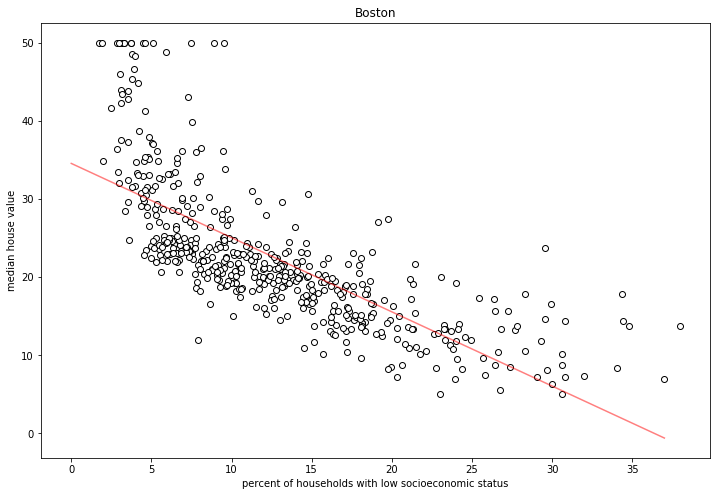

In [10]:
_, ax = plt.subplots(1, 1, figsize=(12, 8))
resid_line_kw = {'color':'red', 'alpha':0.5}
resid_scatter_kw = {'marker':'o', 'edgecolors':'black', 'color':'white'}
ax.scatter(boston.lstat, boston.medv, **resid_scatter_kw)

# regression line.
intercept, slope = results.params
xs = np.arange(0, max(boston.lstat))
ys = [intercept + x * slope for x in xs]
ax.plot(xs, ys, **resid_line_kw)
ax.set_xlabel('percent of households with low socioeconomic status')
ax.set_ylabel('median house value')
ax.set_title('Boston');

### Residual diagnostic plots

> Note: The book uses `plot(lm.fit)` to generate these diagnostic plots. Here we'll have to work a little bit to get the same results in python

> For a detailed explanation of these graphs see [this link](https://data.library.virginia.edu/diagnostic-plots/)

__residual vs fitted__

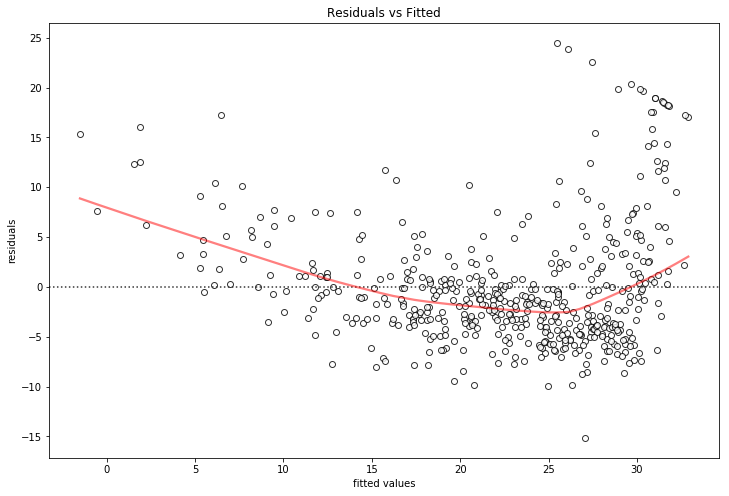

In [11]:
fitted = results.predict(X)
residuals = boston.medv - fitted
_, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.residplot(fitted, residuals, lowess=True, line_kws=resid_line_kw, scatter_kws=resid_scatter_kw, ax=ax)
ax.set_xlabel('fitted values')
ax.set_ylabel('residuals')
ax.set_title('Residuals vs Fitted');

__Normal Q-Q plot__

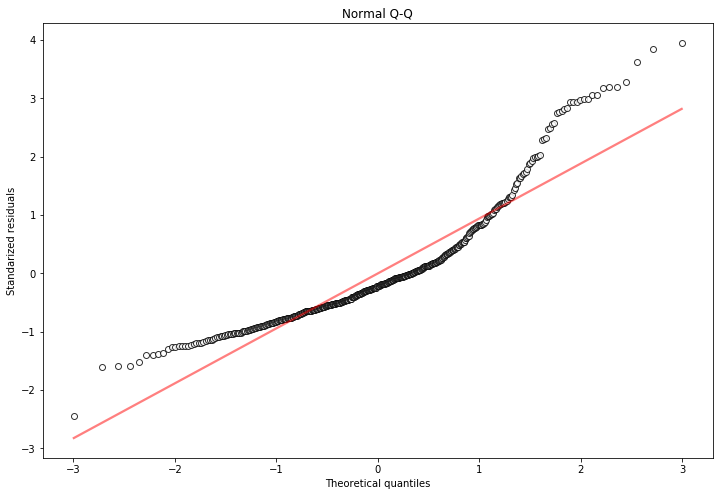

In [12]:
from scipy import stats
from sklearn import preprocessing

fig, ax = plt.subplots(1, 1, figsize=(12,8))

sd_residuals = preprocessing.scale(residuals)

(x, y), (slope, intercept, _) = stats.probplot(sd_residuals, plot=None)
ax.scatter(x, y, **resid_scatter_kw);

ax.plot(x, [_x * slope + intercept for _x in x], **resid_line_kw)
ax.set_title('Normal Q-Q')
ax.set_xlabel('Theoretical quantiles')
ax.set_ylabel('Standarized residuals');

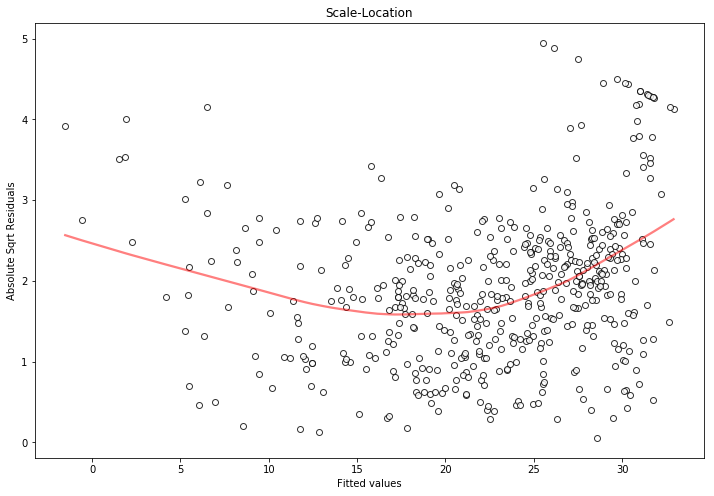

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
abs_sqrt_resid = np.sqrt(np.abs(residuals))
sns.regplot(fitted, abs_sqrt_resid, lowess=True, line_kws=resid_line_kw, scatter_kws=resid_scatter_kw, ax=ax)
ax.set_title('Scale-Location')
ax.set_xlabel('Fitted values')
ax.set_ylabel('Absolute Sqrt Residuals');

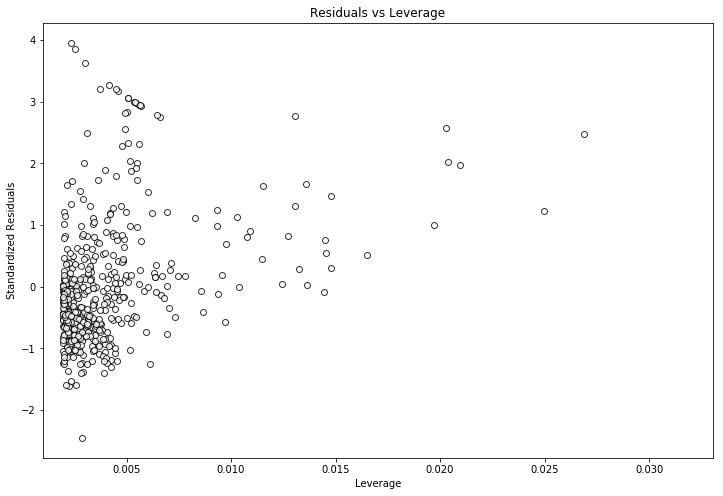

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
leverage = results.get_influence().hat_matrix_diag
ax.scatter(leverage, sd_residuals, **resid_scatter_kw);
ax.set_xlim(0.001, )
ax.set_title('Residuals vs Leverage')
ax.set_xlabel('Leverage')
ax.set_ylabel('Standardized Residuals');

In [22]:
np.square(X.lstat - np.mean(X.lstat)) / 

0       58.875900
1       12.341613
2       74.357220
3       94.343598
4       53.627255
5       55.399190
6        0.049757
7       42.210187
8      298.492544
9       19.775247
10      60.792223
11       0.380611
12       9.344862
13      19.299005
14       5.726752
15      17.498018
16      36.882097
17       4.068034
18       0.927491
19       1.885303
20      70.005631
21       1.385180
22      36.807722
23      52.228615
24      13.300148
25      14.875961
26       4.652376
27      21.408544
28       0.021590
29       0.453014
          ...    
476     36.323967
477    150.232499
478     28.911449
479      0.208791
480      3.659811
481     24.138190
482     31.844163
483      4.986571
484      0.471882
485      4.297591
486      5.414635
487      1.447361
488     29.234965
489    128.073058
490    289.916575
491     29.343204
492      0.485721
493      0.413530
494      0.877850
495     24.472183
496     72.028096
497      2.093626
498      0.071255
499      5.987500
500      2